## STAT5 Dimerization Model

The goal of the notebook is estimate Confidence Bands of [STAT5 Dimerization](doi:10.1021/pr5006923) Model with *LikelihoodProfiler*. STAT5 Dimerization is one of the Benchmark models for [dMod R package](https://github.com/dkaschek/dMod). We have translated the model to [Julia language](https://julialang.org/). [dMod BenchmarkModels repo](https://github.com/dkaschek/dMod/tree/master/BenchmarkModels/Boehm_JProteomeRes2014) contains the model files, experimental data and best-fit parameters.
The model is defined by the following system of differential equations:

In [1]:
using DiffEqBase, OrdinaryDiffEq, CSV, DataFrames, LikelihoodProfiler
using Plots

# constants
const cyt = 1.4
const nuc = 0.45
const ratio = 0.693
const specC17 = 0.107


# ode system
function stat5_ode(du, u, p, time)
    # 8 states:
    (STAT5A, pApA, STAT5B, pApB, pBpB, nucpApA, nucpApB, nucpBpB) = u
    # 6 parameters
    (Epo_degradation_BaF3, k_exp_hetero, k_exp_homo, k_imp_hetero, k_imp_homo, k_phos) =  p
    
    BaF3_Epo = 1.25e-7*exp(-1*Epo_degradation_BaF3*time)

    v1 = BaF3_Epo*(STAT5A^2)*k_phos
    v2 = BaF3_Epo*STAT5A*STAT5B*k_phos
    v3 = BaF3_Epo*(STAT5B^2)*k_phos
    v4 = k_imp_homo*pApA
    v5 = k_imp_hetero*pApB
    v6 = k_imp_homo*pBpB
    v7 = k_exp_homo*nucpApA
    v8 = k_exp_hetero*nucpApB
    v9 = k_exp_homo*nucpBpB

    du[1] = -2*v1 - v2 + 2*v7*(nuc/cyt) + v8*(nuc/cyt)
    du[2] = v1 - v4
    du[3] = -v2 -2*v3 + v8*(nuc/cyt) + 2*v9*(nuc/cyt)
    du[4] = v2 - v5
    du[5] = v3 - v6
    du[6] = v4*(cyt/nuc) - v7
    du[7] = v5*(cyt/nuc) - v8
    du[8] = v6*(cyt/nuc) - v9
end;

Let's load the experimental dataset 

In [ ]:
data = CSV.read("data_stat5.csv", DataFrame);

Observables, initial values and solver settings are set according to [model's files](https://github.com/dkaschek/dMod/tree/master/BenchmarkModels/Boehm_JProteomeRes2014) and [dMod settings](https://github.com/dkaschek/dMod/blob/master/R/PEtab2dMod.R)

In [4]:
saveat = Float64.(data[!,:time])
tspan = (0.,saveat[end])

u0 = zeros(8)
u0[1] = 207.6*ratio         # STAT5A
u0[3] = 207.6 - 207.6*ratio # STAT5B

prob(p) = ODEProblem(stat5_ode, eltype(p).(u0), tspan, p)

function solve_prob(p)
    _prob = prob(p)

    # solution
    sol = solve(_prob, AutoTsit5(Rosenbrock23()), saveat=saveat, reltol=1e-3,abstol=1e-6) #save_idxs=[1,2,3,4,5] 
    STAT5A = sol[1,:]
    pApA = sol[2,:]
    STAT5B = sol[3,:]
    pApB = sol[4,:]
    pBpB = sol[5,:]

    # observables
    pSTAT5A_rel = (100 * pApB + 200 * pApA * specC17) ./ (pApB + STAT5A * specC17 + 2 * pApA * specC17)
    pSTAT5B_rel = -(100 * pApB - 200 * pBpB * (specC17 - 1)) ./ ((STAT5B * (specC17 - 1) - pApB) + 2 * pBpB * (specC17 - 1))
    rSTAT5A_rel = (100 * pApB + 100 * STAT5A * specC17 + 200 * pApA * specC17) ./ (2 * pApB + STAT5A * specC17 + 2 * pApA * specC17 - STAT5B * (specC17 - 1) - 2 * pBpB * (specC17 - 1))

    return [pSTAT5A_rel, pSTAT5B_rel, rSTAT5A_rel]
end;

The [best-fit](https://github.com/dkaschek/dMod/blob/master/BenchmarkModels/Boehm_JProteomeRes2014/parameters_Boehm_JProteomeRes2014.tsv) parameters values:

In [6]:
p_best = [
    0.026982514033029,      # Epo_degradation_BaF3
    0.0000100067973851508,  # k_exp_hetero
    0.006170228086381,      # k_exp_homo
    0.0163679184468,        # k_imp_hetero
    97749.3794024716,       # k_imp_homo
    15766.5070195731,       # k_phos
    3.85261197844677,       # sd_pSTAT5A_rel
    6.59147818673419,       # sd_pSTAT5B_rel
    3.15271275648527        # sd_rSTAT5A_rel
];

Let's run the simulations and plot results for best-fit parameters values

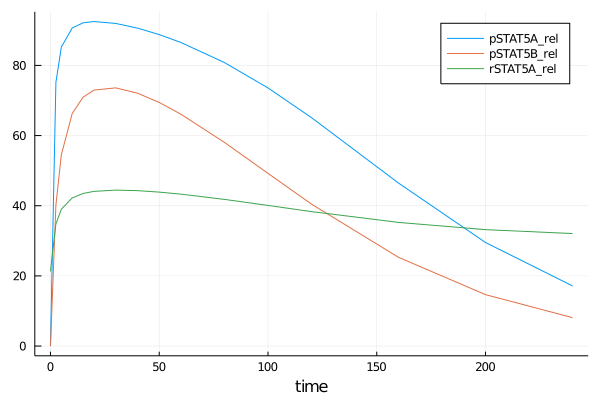

In [7]:
sol = solve_prob(p_best)
plot(saveat,sol, label=["pSTAT5A_rel" "pSTAT5B_rel" "rSTAT5A_rel"], xlabel=:time)

Loss function includes parameters transformation to log10 scale:

In [10]:
function loss_func(p_init)
    p = exp10.(p_init)

    sim = solve_prob(p)
    σ = p[7:9]
    # loss
    return loss(sim,data,σ)
end

function loss(sim,data,σ)
    loss = 0.0
    obs = names(data)[2:end]  

    for i in 1:length(obs)
        loss_i = loss_component(sim[i],data[!,i+1],σ[i])
        loss += loss_i
    end
    return loss
end

function loss_component(sim,data,σ)
    loss_i = 0.0
    
    for i in eachindex(sim)
            loss_i += ((sim[i]-data[i])/σ)^2 + 2*log(sqrt(2π)*σ)
    end
    return loss_i
end;

Now we are ready to estimate Confidence Bands with *LikelihoodProfiler*

In [34]:
α = loss_func(log10.(p_best)) + 3.84 # chisq with 1 df

# search CI with LikelihoodProfiler
num_params = length(p_best)
p_log = log10.(p_best)

function bands_pSTAT5A(parampampam, i)
    p = exp10.(parampampam)
    sol = solve_prob(p)
    sol[1][i]
end

function bands_pSTAT5B(parampampam, i)
    p = exp10.(parampampam)
    sol = solve_prob(p)
    sol[2][i]
end

function bands_rSTAT5A(parampampam, i)
    p = exp10.(parampampam)
    sol = solve_prob(p)
    sol[3][i]
end

tbounds = fill((-6.,6.), num_params)
sbounds = (-3.,120.);

*Confidence bands* for pSTAT5A:

In [53]:
intervals = Vector{ParamInterval}(undef,length(saveat))
for i in eachindex(saveat)
    @time intervals[i] = get_interval(
        p_log,
        p->bands_pSTAT5A(p,i),
        loss_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = tbounds,
        scan_bounds = sbounds,
        scan_tol = 1e-2,
        local_alg = :LN_NELDERMEAD,
    )
end

  1.445334 seconds (1.75 M allocations: 102.486 MiB, 2.85% gc time)
 11.258178 seconds (15.48 M allocations: 1.063 GiB, 3.62% gc time)
 12.470560 seconds (15.83 M allocations: 1.085 GiB, 3.13% gc time)
  9.760224 seconds (9.90 M allocations: 694.521 MiB, 2.80% gc time)
  5.206169 seconds (4.12 M allocations: 289.542 MiB, 2.30% gc time)
  5.754010 seconds (7.59 M allocations: 532.087 MiB, 3.25% gc time)
  3.998124 seconds (5.73 M allocations: 401.710 MiB, 3.34% gc time)
  3.933089 seconds (5.49 M allocations: 385.072 MiB, 3.45% gc time)
  6.192696 seconds (8.13 M allocations: 570.225 MiB, 3.49% gc time)
  8.307988 seconds (9.62 M allocations: 675.639 MiB, 3.14% gc time)
 12.846417 seconds (14.99 M allocations: 1.027 GiB, 2.71% gc time)
 11.354914 seconds (12.98 M allocations: 913.073 MiB, 2.63% gc time)
 12.453824 seconds (17.15 M allocations: 1.177 GiB, 3.24% gc time)
  8.950704 seconds (13.00 M allocations: 913.658 MiB, 3.28% gc time)
  7.211264 seconds (10.47 M allocations: 735.730 M

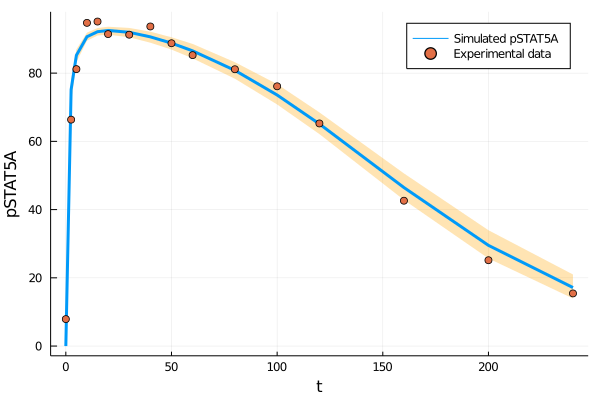

In [54]:
lbands = [iv.result[1].value for iv in intervals]
ubands = [iv.result[2].value for iv in intervals]
u = sol[1]

plot(saveat, u, xlabel = "t", ylabel = "pSTAT5A", label="Simulated pSTAT5A", line=3,
ribbon = (u-lbands, ubands-u), fc=:orange, fa=0.3);
scatter!(data.time, data.pSTAT5A_rel, label = "Experimental data")

*Confidence bands* for pSTAT5B:

In [55]:
intervals = Vector{ParamInterval}(undef,length(saveat))
for i in eachindex(saveat)
    @time intervals[i] = get_interval(
        p_log,
        p->bands_pSTAT5B(p,i),
        loss_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = tbounds,
        scan_bounds = sbounds,
        scan_tol = 1e-2,
        local_alg = :LN_NELDERMEAD,
    )
end

  1.445808 seconds (1.75 M allocations: 102.481 MiB, 3.15% gc time)
 15.399794 seconds (20.45 M allocations: 1.392 GiB, 3.35% gc time)
 10.510984 seconds (12.24 M allocations: 861.173 MiB, 2.67% gc time)
 11.309221 seconds (14.62 M allocations: 1.002 GiB, 3.14% gc time)
 13.313606 seconds (12.76 M allocations: 897.835 MiB, 2.44% gc time)
 10.418095 seconds (11.94 M allocations: 838.845 MiB, 3.28% gc time)
 10.719887 seconds (14.47 M allocations: 1016.328 MiB, 3.06% gc time)
  8.432835 seconds (12.03 M allocations: 844.590 MiB, 3.11% gc time)
  7.834051 seconds (11.31 M allocations: 793.473 MiB, 3.36% gc time)
 10.827262 seconds (15.80 M allocations: 1.083 GiB, 3.38% gc time)
  9.067547 seconds (12.50 M allocations: 879.042 MiB, 3.25% gc time)
  9.914273 seconds (14.45 M allocations: 1015.409 MiB, 3.30% gc time)
  9.734446 seconds (14.27 M allocations: 1002.468 MiB, 3.34% gc time)
  7.839633 seconds (11.38 M allocations: 800.349 MiB, 3.38% gc time)
  9.378016 seconds (13.66 M allocation

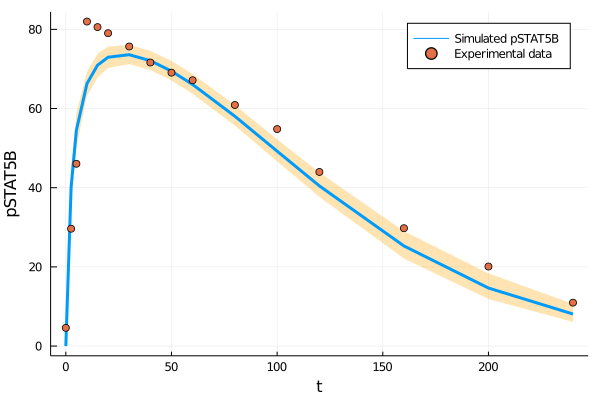

In [56]:
lbands = [iv.result[1].value for iv in intervals]
ubands = [iv.result[2].value for iv in intervals]
u = sol[2]

plot(saveat, u, xlabel = "t", ylabel = "pSTAT5B", label="Simulated pSTAT5B", line=3,
ribbon = (u-lbands, ubands-u), fc=:orange, fa=0.3);
scatter!(data.time, data.pSTAT5B_rel, label = "Experimental data")

*Confidence bands* for rSTAT5A:

In [57]:
intervals = Vector{ParamInterval}(undef,length(saveat))
for i in eachindex(saveat)
    @time intervals[i] = get_interval(
        p_log,
        p->bands_rSTAT5A(p,i),
        loss_func,
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = tbounds,
        scan_bounds = sbounds,
        scan_tol = 1e-2,
        local_alg = :LN_NELDERMEAD,
    )
end

  1.529419 seconds (1.75 M allocations: 102.478 MiB, 2.61% gc time)
  8.195781 seconds (10.78 M allocations: 755.693 MiB, 3.40% gc time)
  5.506189 seconds (7.33 M allocations: 514.525 MiB, 3.02% gc time)
  3.848368 seconds (5.10 M allocations: 358.114 MiB, 2.58% gc time)
  7.379553 seconds (9.46 M allocations: 664.328 MiB, 3.22% gc time)
  2.619979 seconds (3.77 M allocations: 264.880 MiB, 2.48% gc time)
 11.258890 seconds (12.15 M allocations: 854.255 MiB, 3.07% gc time)
 10.356649 seconds (9.51 M allocations: 668.349 MiB, 2.80% gc time)
  4.274973 seconds (4.10 M allocations: 288.355 MiB, 2.73% gc time)
  1.792207 seconds (2.11 M allocations: 147.998 MiB, 2.05% gc time)
  9.412505 seconds (10.96 M allocations: 771.448 MiB, 3.29% gc time)
  3.295689 seconds (3.92 M allocations: 275.614 MiB, 2.22% gc time)
  7.955384 seconds (9.08 M allocations: 637.335 MiB, 3.21% gc time)
 14.746175 seconds (16.35 M allocations: 1.120 GiB, 2.75% gc time)
 15.344756 seconds (19.00 M allocations: 1.303

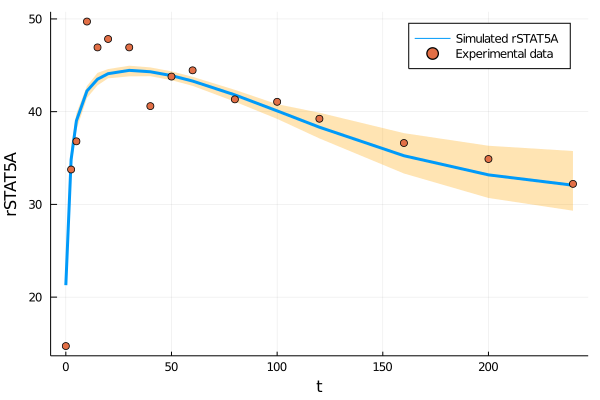

In [59]:
lbands = [iv.result[1].value for iv in intervals]
ubands = [iv.result[2].value for iv in intervals]
u = sol[3]

plot(saveat, u, xlabel = "t", ylabel = "rSTAT5A", label="Simulated rSTAT5A", line=3,
ribbon = (u-lbands, ubands-u), fc=:orange, fa=0.3);
scatter!(data.time, data.rSTAT5A_rel, label = "Experimental data")